In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import cv2 as cv

In [2]:
%run -i ../ownlib/RIW-Library.ipynb
%run -i ../ownlib/Utility.ipynb
%run -i ../ownlib/PHT-Library3.ipynb

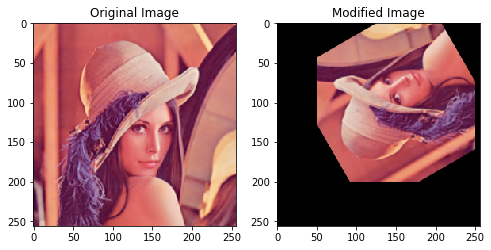

In [58]:
N = 256

img1 = cv2.imread('lena.png')
img1 = attackResize(img1, 256)

tmp = attackResize(img1, 200)
tmp = attackRotation(tmp, 120)

img2 = np.zeros((256, 256, 3)).astype('uint8')
img2[0:200, 50:250, :] = tmp
# img2 = attackTranslate(img2, 0.1, -0.1)
# img2 = attackResize(img2, 100)

# img2 = np.copy(img1)
# img2 = attackRotation(img2, 120)
# img2 = attackTranslate(img2, 0.1, 0.1)

imgshow([[img1, img2]], [['Original Image', 'Modified Image']])

In [34]:
def kp2pt(kp):
    (px, py) = kp.pt
    return (int(px), int(py))

def getPairs(keypointmathces, keypoints1, keypoints2):
    pairs = []
    for mt in keypointmathces:
        p1 = keypoints1[mt.queryIdx]
        p2 = keypoints2[mt.trainIdx]
        pairs.append((kp2pt(p1), kp2pt(p2)))
    return pairs

def calcDist(pa, pb):
    (pax, pay) = pa
    (pbx, pby) = pb
    dx = pax - pbx
    dy = pay - pby
    return np.sqrt(dx * dx + dy * dy)

def addTupple(t1, t2):
    (t1x, t1y) = t1
    (t2x, t2y) = t2
    return (t1x + t2x, t1y + t2y)

def calcError(keypointmathces, keypoints1, keypoints2, center1, center2, s):
    pairs = getPairs(keypointmathces, keypoints1, keypoints2)
    sum = 0
    for (p1, p2) in pairs:
        d1 = calcDist(p1, center1)
        d2 = s * calcDist(p2, center2)
        sum += abs(d1 - d2)
    return sum / len(pairs)

def optimizeCenter(keypointmathces, keypoints1, keypoints2, c1, c2):
    dx = 0
    dy = 0
    s = 1
    d_step = 0.1
    s_step = 0.0005
    N_STEP = 10000
    
    err = 0
    
    update_progress(0)
    for i in range(N_STEP):
        
        if(i%3 == 0):
            e1 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx + d_step, c2 + dy), s)
            e2 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx - d_step, c2 + dy), s)
            if(e1 < e2):
                err = e1
                dx += d_step
            else:
                err = e2
                dx -= d_step
        elif(i%3 == 1):
            e1 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx, c2 + dy + d_step), s)
            e2 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx, c2 + dy - d_step), s)
            if(e1 < e2):
                err = e1
                dy += d_step
            else:
                err = e2
                dy -= d_step
        else:
            e1 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx, c2 + dy), s + s_step)
            e2 = calcError(keypointmathces[:], keypoints1, keypoints2, (c1, c1), (c2 + dx, c2 + dy), s - s_step)
            if(e1 < e2):
                err = e1
                s += s_step
            else:
                err = e2
                s -= s_step
        
        if(i%100 == 0):
            update_progress(i/N_STEP, err)
    
    update_progress(1, err)
    return (int(np.round(-dx)), int(np.round(-dy)), s)

In [45]:
def correctTranslate(original, attacked):
    
    # Initiate ORB detector
    orb = cv2.ORB_create()
    
    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(original,None)
    kp2, des2 = orb.detectAndCompute(attacked,None)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1, des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    (c1, *_) = original.shape
    (c2, *_) = attacked.shape
    
    return optimizeCenter(matches[:50], kp1, kp2, (c1 - 1) / 2, (c2 - 1) / 2)

In [36]:
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [37]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1, des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

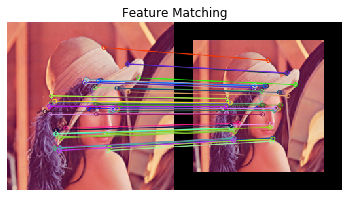

In [38]:
imgshow1(img3, 'Feature Matching')

0.6658516152293573
Progress: [####################] 100.0%
0 0 1.2834999999999688


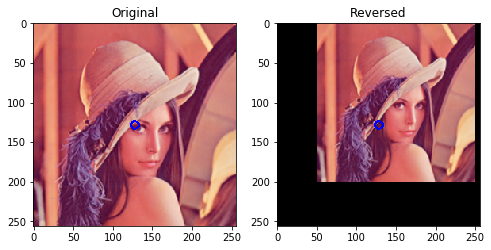

In [53]:
(n1, *_) = img1.shape
(n2, *_) = img2.shape
(tx, ty, s) = optimizeCenter(matches[:50], kp1, kp2, (n1 - 1) / 2, (n2 - 1) / 2)
print(tx, ty, s)

img1marked = cv2.circle(np.copy(img1), (int(n1/2), int(n1/2)), 5, (255, 0, 0), 2) 
img2marked = cv2.circle(np.copy(img2), (int(n2/2) - tx, int(n2/2) - ty), 5, (255, 0, 0), 2)
imgshow([[img1marked, img2marked]], [['Original', 'Reversed']])

0.794042286309771
Progress: [####################] 100.0%
-22 28 1.2834999999999688


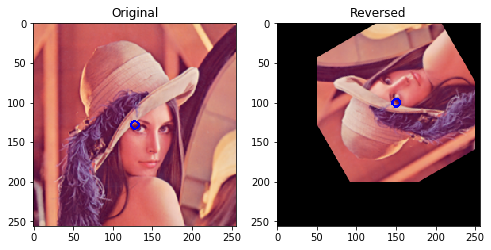

In [59]:
(n1, *_) = img1.shape
(n2, *_) = img2.shape
(tx, ty, s) = correctTranslate(img1, img2)
img1marked = cv2.circle(np.copy(img1), (int(n1/2), int(n1/2)), 5, (255, 0, 0), 2) 
img2marked = cv2.circle(np.copy(img2), (int(n2/2) - tx, int(n2/2) - ty), 5, (255, 0, 0), 2)
imgshow([[img1marked, img2marked]], [['Original', 'Reversed']])
print(tx, ty, s)

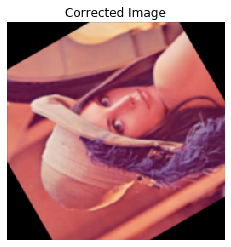

In [60]:
n3 = int(np.round(s * n2))
frameSize = int((n3 - n1)/2)

imgCorr = attackTranslateByPixel(img2, tx, ty)
imgCorr = attackResize(imgCorr, n3)
imgCorr = imgCorr[frameSize:n1+frameSize, frameSize:n1+frameSize, :]

imgshow1(imgCorr, 'Corrected Image')

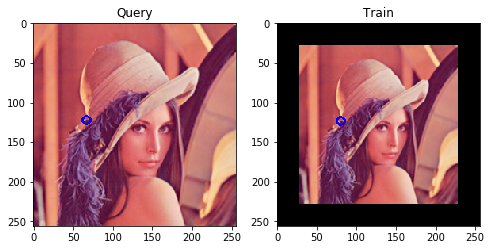

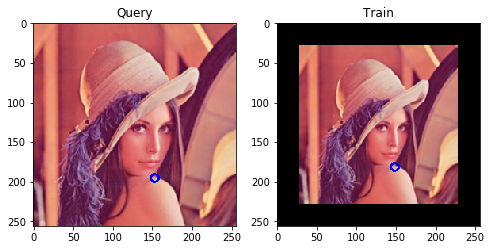

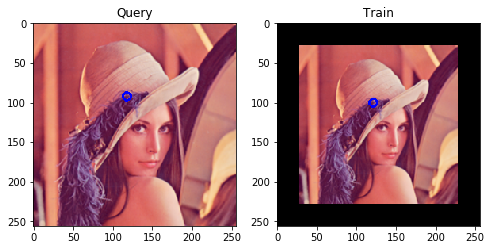

In [12]:
for pair in getPairs(matches[:3], kp1, kp2):
    (p1, p2) = pair
    img1edit = cv2.circle(np.copy(img1), p1, 5, (255, 0, 0), 2) 
    img2edit = cv2.circle(np.copy(img2), p2, 5, (255, 0, 0), 2)
    imgshow([[img1edit, img2edit]], [['Query', 'Train']])